In [ ]:
import tempfile
import pandas as pd

In [ ]:
df = pd.read_csv("data/llm_matchmaker_dataset_1000.csv")
original_df = df.copy()
print(df.info())
df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   task_type                1000 non-null   object 
 1   domain                   1000 non-null   object 
 2   input_language           1000 non-null   object 
 3   privacy_requirement      1000 non-null   object 
 4   hardware_available       1000 non-null   object 
 5   hallucination_tolerance  1000 non-null   object 
 6   determinism_needed       1000 non-null   int64  
 7   temperature_pref         1000 non-null   object 
 8   output_style             1000 non-null   object 
 9   best_model               1000 non-null   object 
 10  score_GPT-4o             1000 non-null   float64
 11  score_Gemini             1000 non-null   float64
 12  score_Claude-2           1000 non-null   float64
 13  score_Llama-3-70B        1000 non-null   float64
 14  score_Deepseek           

,task_type,domain,input_language,privacy_requirement,hardware_available,hallucination_tolerance,determinism_needed,temperature_pref,output_style,best_model,score_GPT-4o,score_Gemini,score_Claude-2,score_Llama-3-70B,score_Deepseek
291,classification,ecommerce,multi,hybrid,cpu,medium,0,low,precise,Llama-3-70B,-0.152,1.051,2.976,4.858,1.235
410,summarization,legal,pt,local,cpu,medium,0,high,factual,Llama-3-70B,0.365,2.227,-1.232,4.239,4.031
377,classification,legal,multi,cloud,cpu,medium,0,low,factual,Claude-2,0.256,2.238,4.485,4.205,0.797
211,classification,ecommerce,pt,cloud,cpu,high,0,medium,precise,Llama-3-70B,0.066,0.895,1.635,3.909,1.726
238,extraction,technical,multi,cloud,edge,medium,0,medium,creative,Deepseek,0.721,-0.267,-0.120,2.064,3.381


In [ ]:
target = "best_model"
features = [col for col in df.columns if col != target and not col.startswith("score_")]

print("Target:", target)
print("Features:", features)

Target: best_model
Features: ['task_type', 'domain', 'input_language', 'privacy_requirement', 'hardware_available', 'hallucination_tolerance', 'determinism_needed', 'temperature_pref', 'output_style']


In [ ]:
X = df[features]
y = df[target]

In [ ]:
categorical_features = [col for col in X.columns if col != "determinism_needed"]

categorical_features

['task_type',
 'domain',
 'input_language',
 'privacy_requirement',
 'hardware_available',
 'hallucination_tolerance',
 'temperature_pref',
 'output_style']

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.base import clone
from tqdm import tqdm

In [ ]:
pipeline = Pipeline(steps=[
    ("preprocessor", ColumnTransformer(
        transformers=[
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
        ]
    )),
    ("classifier", RandomForestClassifier(random_state=42, n_jobs=1)),
], memory=tempfile.mkdtemp())

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [ ]:
param_grid = {
    "classifier__n_estimators": [100, 300],
    "classifier__max_depth": [None, 10, 20],
    "classifier__min_samples_split": [2, 5, 10],
    "classifier__min_samples_leaf": [1, 2, 4],
    "classifier__max_features": ["sqrt", "log2", None],
    "classifier__bootstrap": [True, False],
    "classifier__max_leaf_nodes": [None, 50, 100],
}

In [ ]:
N_SPLITS = 5
N_TRIALS = 15
N_ITER = 200
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

In [ ]:
all_results = []

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=N_ITER, 
    cv=skf,
    n_jobs=-1,
    scoring="accuracy",
    random_state=42,
    verbose=2
)

random_search.fit(X_train, y_train)
print("Best Parameters:", random_search.best_params_)
print("Best CV Accuracy:", random_search.best_score_)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=log2, classifier__max_leaf_nodes=None, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   0.2s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=log2, classifier__max_leaf_nodes=None, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   0.2s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=log2, classifier__max_leaf_nodes=None, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=100; total time=   0.2s
[CV] END classifier__bootstrap=True, classifier__max_depth=None, classifier__max_features=log2, classifier__max_leaf_nodes=None, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifie

In [ ]:
best_model = random_search.best_estimator_
best_model.fit(X_train, y_train)

Pipeline(memory='/tmp/tmp158fxqod',
         steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['task_type', 'domain',
                                                   'input_language',
                                                   'privacy_requirement',
                                                   'hardware_available',
                                                   'hallucination_tolerance',
                                                   'temperature_pref',
                                                   'output_style'])])),
                ('classifier',
                 RandomForestClassifier(max_features=None, min_samples_split=5,
                                        n_jobs=1, random_state=42))])

In [ ]:
y_true = y_test
y_pred = best_model.predict(X_test)

Test Set Classification Report:               precision    recall  f1-score   support

    Claude-2       0.80      0.85      0.83        61
    Deepseek       0.81      0.76      0.79        75
      GPT-4o       0.58      0.39      0.47        18
      Gemini       0.82      0.88      0.85        76
 Llama-3-70B       0.83      0.84      0.84        70

    accuracy                           0.81       300
   macro avg       0.77      0.75      0.75       300
weighted avg       0.80      0.81      0.80       300



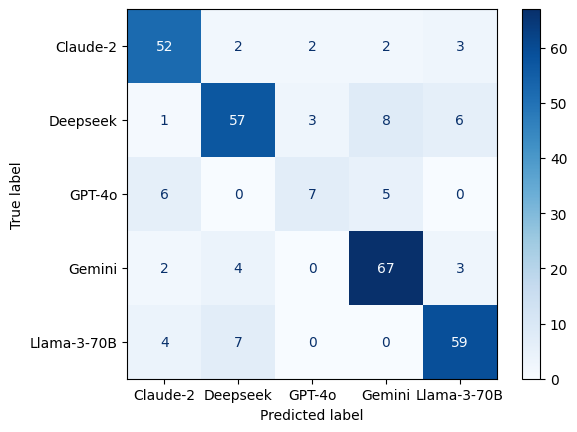

In [ ]:
print(f"Test Set Classification Report: {classification_report(y_true, y_pred)}")
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap="Blues")

In [ ]:
import joblib

In [ ]:
best_model_filepath = "models/best_llm_matchmaker_model.joblib"
joblib.dump(best_model, best_model_filepath)
print(f"Best model saved to {best_model_filepath}")

Best model saved to models/best_llm_matchmaker_model.joblib
